# Statistics summary
This notebook is a brief introduction to various statistical analyses commonly used for amplicon data analysis - including some basic theory, links to more in-depth explanations, how to run them in R, and how to ensure the assumptions hold.

### Getting more in-depth
Excellent introductions to various statistical concepts and analysis can be found in a [Nature Methods collection of 2-page letters aimed at biologists](https://www.nature.com/collections/qghhqm/pointsofsignificance).

The first paper, [Importance of being uncertain](http://www.nature.com/doifinder/10.1038/nmeth.2613), is a must read for anyone new to statistics.

The [GUSTA ME website](https://mb3is.megx.net/gustame) contains descriptions of many multivariate analyses aimed at microbial ecologists using R.


# Contents
* [Example datasets](#data)
* [Two sample T-test](#t-test)
* [Wilcoxon Rank Sum test](#wilcoxon)
* [Paired two-sample tests](#paired)
* [Correlation](#correlation)
* [Linear regression](#regression)
* [ANOVA](#anova)
* [Linear model](#linear_model)
* [Mixed-effect linear model](#mixed)
* [Interactions](#interactions)
* [Ordinations](#ordination)
* [PCA](#pca)
* [PCoA](#pcoa)
* [PERMANOVA](#permanova)
* [Corrections for multiple comparisons](#multiple)


In [1]:
# Load packages
library(ggplot2) # Plotting

# Example datasets<a class="anchor" id="data"></a>
**mtcars:** The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles

In [2]:
data(mtcars)

**pairedData**: A data.frame with randomly generated paired data

In [3]:
# Set seed (for reproducibility when doing things that involves randomness)
set.seed(42)
# Set number of samples
nSamples <- 10
# Build data.frame with random measurements
pairedData <- data.frame(sampletime = c(rep("before", nSamples), rep("after", nSamples)),
                        subject = rep(LETTERS[1:nSamples], 2),
                         measurement = rnorm(nSamples * 2))
# Shuffle data.frame
pairedData <- pairedData[sample(1:nrow(pairedData)), ]

# Two sample T-test <a class="anchor" id="t-test"></a>
The two-sample t-test is used for comparing the means of two samples; for example comparing a control condition with a treatment.

### Assumptions
1. Samples are uncorrelated. This is the most crucial assumption: Samples should be independent. If the samples are paired, for example with before and after measurements, or in other ways correlated one-to-one, use the paired t-test.

2. Samples come from a population that have an approximately normal shape. It is quite robust to deviations, but will have higher chance of false positives/negatives with highly non-normal distributions. Transformations (e.g. log transform) can sometimes solve this problem.

3. Variance is equal in the two samples. The t-test is however very robust to deviations from this assumption. In R the default t-test is the Welch variant, which solves the problem of unequal variances from unequal sample sizes.

### In R
Let's compare the engine displacement of cars with automatic transmission (am = 1) compared to manual transmission (am = 0)

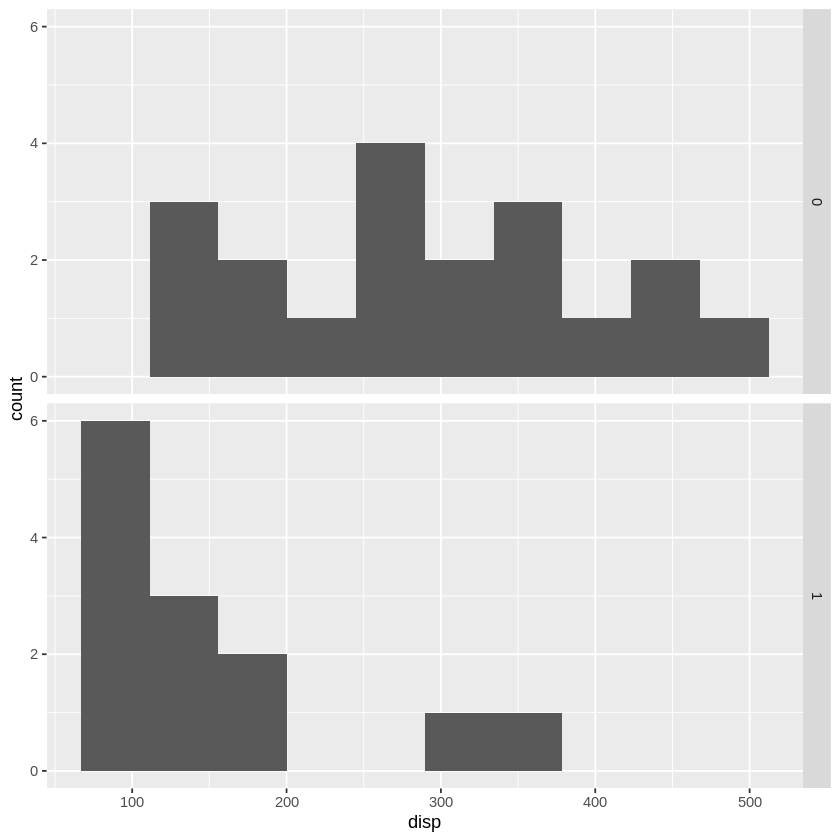

In [4]:
ggplot(mtcars, aes(disp)) + facet_grid(am ~ .) + geom_histogram(bins = 10)

In [5]:
t.test(disp ~ am, data = mtcars) 


	Welch Two Sample t-test

data:  disp by am
t = 4.1977, df = 29.258, p-value = 0.00023
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  75.32779 218.36857
sample estimates:
mean in group 0 mean in group 1 
       290.3789        143.5308 


We can see that the average displacement in cars with manual transmission (group 0) is 290, and in cars with automatic transmission (group 1) is 144. This difference is significant with a p-value of 0.00023. The difference between the two is between 75 and 218 (95% confidence interval)

# Wilcoxon Rank Sum test <a class="anchor" id="wilcoxon"></a>
The Wilcoxon Rank Sum test is used to compare the medians of two samples, similar to a two sample t-test. This test is however non-parametric and therefore has (almost) no assumptions on the distributions of the populations. It is less powerful than the t-test, especially for small (n<10) sample sizes.

### Assumptions
1. Similar to the t-test, the samples should be uncorrelated and independent. A paired version of this test is the Wilcoxon Signed Rank test.

2. The two samples should be drawn from populations with approximately similar shape. 

### In R:
Let's compare the engine displacement of cars with automatic transmission (am = 1) compared to manual transmission (am = 0)

In [6]:
wilcox.test(disp ~ am, data = mtcars) 

Warning message in wilcox.test.default(x = c(258, 360, 225, 360, 146.7, 140.8, 167.6, :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  disp by am
W = 214, p-value = 0.0005493
alternative hypothesis: true location shift is not equal to 0


We can see that the average displacement in cars with manual transmission (group 0) is different than in cars with automatic transmission (group 1) a p-value of 0.0005493. The warnings tells us that some displacement values are similar, which means the p-value is an approximation. This is not problematic unless there are many ties.

# Paired two sample tests <a class="anchor" id="paired"></a>
If samples are paired, a paired test should be used. This should be used to for example before and after measurements on the same subjects. See the above two sections for assumptions.

In R it is crucial that the observations are in correct order, as the samples are paired according to the input order.

### Ordering data in R

If we look at the dataset, we can see that it is unordered:

In [7]:
pairedData

,sampletime,subject,measurement
11,after,A,1.30486965
15,after,E,-0.13332134
8,before,H,-0.09465904
4,before,D,0.63286260
17,after,G,-0.28425292
6,before,F,-0.10612452
2,before,B,-0.56469817
13,after,C,-1.38886070
12,after,B,2.28664539
5,before,E,0.40426832


Let's order it by subject:

In [8]:
pairedDataOrder <- pairedData[order(pairedData$subject), ]
pairedDataOrder

,sampletime,subject,measurement
11,after,A,1.30486965
1,before,A,1.37095845
2,before,B,-0.56469817
12,after,B,2.28664539
13,after,C,-1.38886070
3,before,C,0.36312841
4,before,D,0.63286260
14,after,D,-0.27878877
15,after,E,-0.13332134
5,before,E,0.40426832


### Paired t-test in R

In [9]:
before <- pairedDataOrder[pairedDataOrder$sampletime == "before", "measurement"]
after <- pairedDataOrder[pairedDataOrder$sampletime == "after", "measurement"]

t.test(after, before, paired = TRUE)


	Paired t-test

data:  after and before
t = -1.0742, df = 9, p-value = 0.3107
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.2075921  0.7860851
sample estimates:
mean of the differences 
             -0.7107535 


The average difference between before and after measurements is -0.71 (-2.21 to 0.79, 95% CI) and this is not statistically significant, p-value = 0.3107. 

Also notice that we only have 9 degrees of freedom, despite having 20 observations in the input data.frame. This is because we have repeated measurements within subjects, and we actually only have 10 independent measurements. A paired t-test is therefore equivalent to finding the difference between before and after measuremnts and then running a one-sample t-test:

In [10]:
# Find the difference
difference <- after - before
difference

[1] -0.06608879  2.85134356 -1.75198911 -0.91165137 -0.53758966  0.74207491
 [7] -1.79577492 -2.56179638 -4.45889064  1.38282744

In [11]:
# One-sample t-test
t.test(difference, mu = 0)


	One Sample t-test

data:  difference
t = -1.0742, df = 9, p-value = 0.3107
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -2.2075921  0.7860851
sample estimates:
 mean of x 
-0.7107535 


This result is exactly identical to the paired two-sample test.

# Correlation <a class="anchor" id="correlation"></a>
It is advised to read [this excellent introduction to the difference between correlation, association, and causation](https://www.nature.com/articles/nmeth.3587).

As the above paper states: *two variables are correlated when they display an increasing or decreasing trend*

Correlation values range between 1 for perfect positive trend, 0 for no trend, to -1 for perfect negative trend. There are two types of correlation metrics that are typically used. Pearson's *r* and and Spearman's *rho*. Pearsons is used for linear trends, and Spearmans is used for monotonic trends. See the below graph from the Wikipedia page on Spearmans correlation:


![Pearson vs Spearman](../img/spearman_pearson.png)

### Assumptions
Pearsons assume linearity between variables, and Spearmans assume monotonic trend between variables. Pearsons further assume that both variables are (somewhat) normally distributed and homoscedasticity. Homoscedasticity, as oppossed to heteroscedasticity means that the variance is not changing across the range of values. See the following example

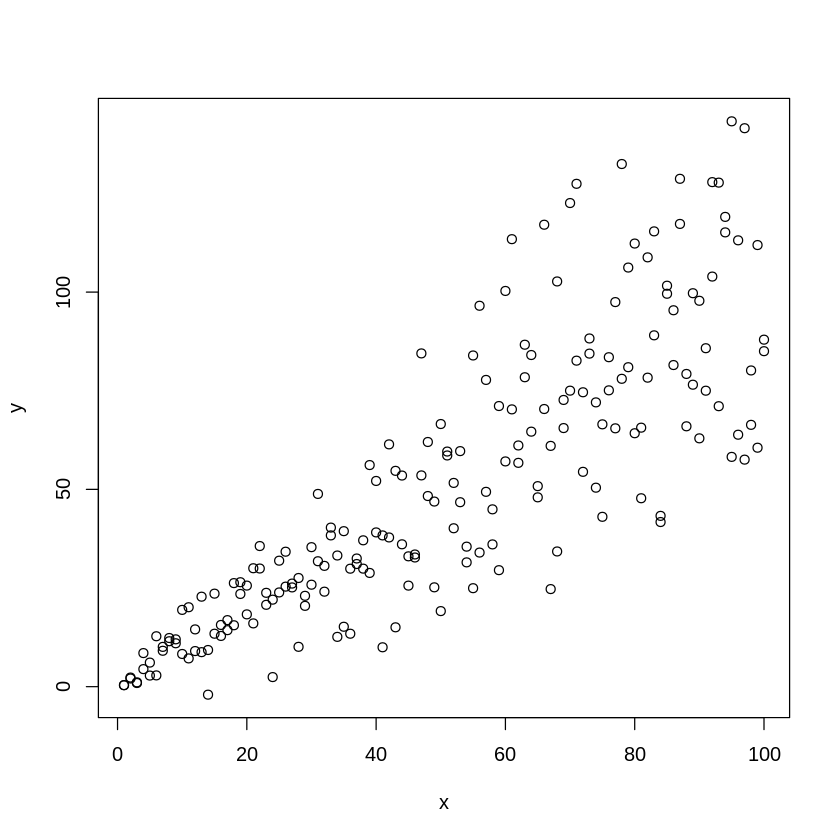

In [94]:
# Simulate heteroscedastic data
set.seed(1)
x <- rep(1:100, 2)
y <- x + rnorm(x, 0, sqrt(x^1.5))
plot(x, y)

The above plot is an example of heteroscedasticity; the variance (distance between data points) changes as x and y increases. If your data is distributed like this you should consider transforming your data, or perform analyses which can handle these distributions.

### In R:

Pearson's is calculated with the cor function. Here we find the correlation between horsepower and engine displacement from the car data:

In [106]:
cor(mtcars$disp, mtcars$hp)

[1] 0.7909486

The order of the variables does not matter:

In [107]:
cor(mtcars$hp, mtcars$disp)

[1] 0.7909486

Let's try the same with Spearman's correlation:

In [108]:
cor(mtcars$disp, mtcars$hp, method="spearman")

[1] 0.8510426

Spearman is basically a Pearson's correlation on ranked data:

In [109]:
cor(rank(mtcars$disp), rank(mtcars$hp))

[1] 0.8510426

Let's make a plot to visualize the trend between the two variables:

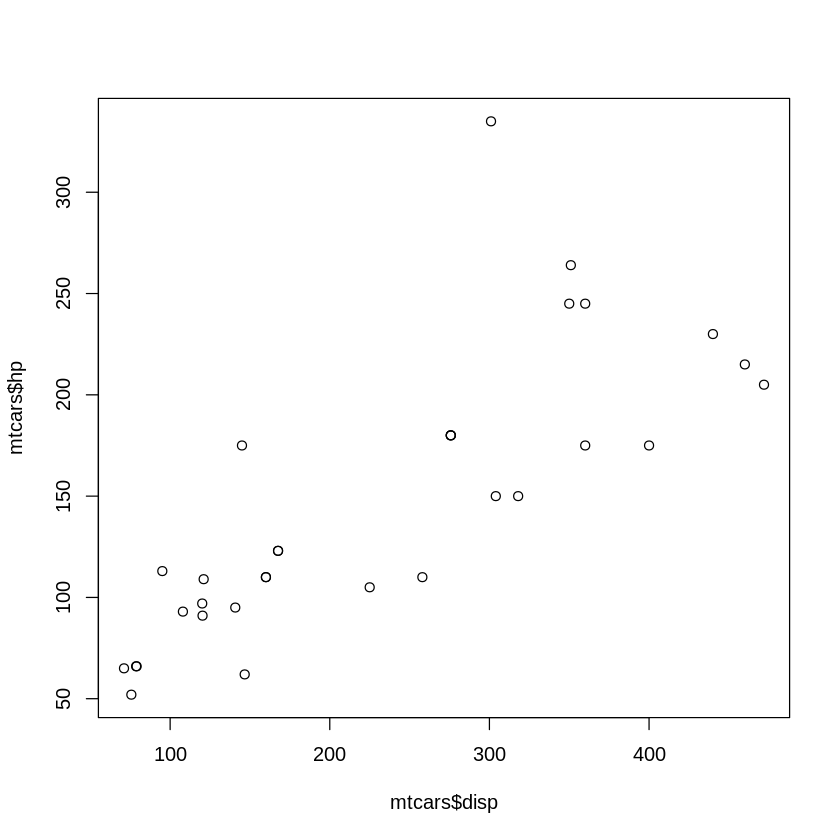

In [110]:
plot(mtcars$disp, mtcars$hp)

We can get p-values by using the cor.test function with the same input:

In [111]:
cor.test(mtcars$disp, mtcars$hp)


	Pearson's product-moment correlation

data:  mtcars$disp and mtcars$hp
t = 7.0801, df = 30, p-value = 7.143e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6106794 0.8932775
sample estimates:
      cor 
0.7909486 


In [112]:
cor.test(mtcars$disp, mtcars$hp, method="spearman")

Warning message in cor.test.default(mtcars$disp, mtcars$hp, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  mtcars$disp and mtcars$hp
S = 812.71, p-value = 6.791e-10
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8510426 


# Linear regression <a class="anchor" id="regression"></a>

In a simple linear regression we seek to find how changes in one continuous variable (X) impacts the estimation in another continuous variable (Y). In contrast to correlation, linear regression is asymmetrical, such that swapping X and Y will give a different result. It is based on the assumption that X is fixed (measured perfectly) and that Y is random (with measurement error). Furthermore, it is based on the assumption that the residuals (distance between actual data points and the statistical model) are normally distributed. As with Pearsons correlation there is also an assumption of linearity and homoscedasticity. 

### In R:

Linear regression with engine displacement as indepedent (explanatory) variable and horsepower as dependent (response) variable.  

In [100]:
# Save the model in the fit object
fit <- lm(hp ~ disp, data = mtcars)

# Get a summary of the model:
summary(fit)


Call:
lm(formula = hp ~ disp, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.623 -28.378  -6.558  13.588 157.562 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  45.7345    16.1289   2.836  0.00811 ** 
disp          0.4375     0.0618   7.080 7.14e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.65 on 30 degrees of freedom
Multiple R-squared:  0.6256,	Adjusted R-squared:  0.6131 
F-statistic: 50.13 on 1 and 30 DF,  p-value: 7.143e-08


The important output here are the coefficients and Adjusted R-squared (variance explained). There are two coefficients, one for the Intercept and one for the Y variable (disp). The Estimates are the *estimated* values of the coefficients. As such the model ($Y = a*X + b$) here is estimated as: $hp = 0.4375 * disp + 45.7345$. Our estimate for the horsepower for a car with a engine displacement with 200 is therefore:

In [104]:
0.4375*200 + 45.7345

[1] 133.2345

This result seems to fit with the plot above (see the Correlation section).

The p-values (Pr(>|t|)) tests the hypothesis that the Estimate is zero. A low p-value therefore suggests that the Estimate is unlikely to be zero, given the assumptions of the linear regression. We can therefore see that the engine displacement is significantly associated with the horsepower. Also notice that the p-value is similar to the one from Pearson correlation. The adjusted R-squared tells us that our model *explains* 61.3% of the variance in the horsepower variable.

### Check assumptions in R:

The easiest way to check the assumptions of a linear regression is the plot the fitted model. This produces four plots, which should be used to ensure that the assumptions hold.

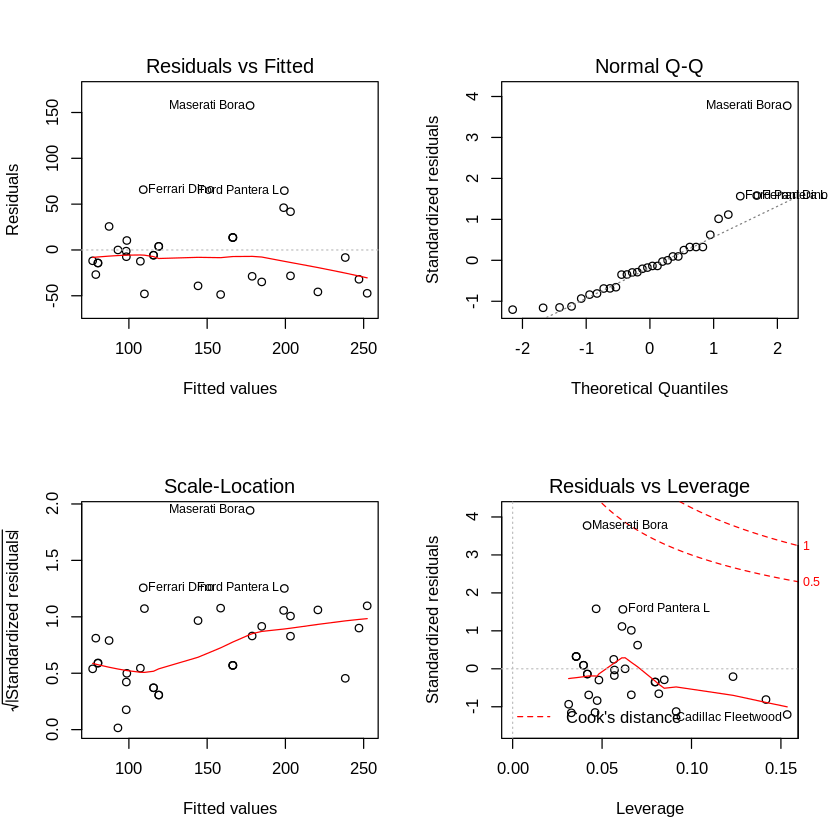

In [113]:
par(mfrow=c(2,2)) # Plot in a 2x2 grid
plot(fit)

#### Residuals vs Fitted
This plot should be used to check for non-linearities in the residuals. The red line should be approximately linear. This is to ensure that there is not some hidden non-linearity that our model does not capture.

#### Normal Q-Q
This plot should be used to chech for normality of residuals. The points should approximately follow the line. If you are unsure how it should look, you can simulate random normally distributed data to get a feel of it. Try to run the below several times with different samples sizes and check the output:
`n_samples <- 20
residuals_simulated <- rnorm(n_samples)
qqnorm(residuals_simulated)
qqline(residuals_simulated)`

#### Scale-Location
This plot should be used to check that residuals are homoscedastistic. The points should have an equal spread across the range of fitted values. If, for example, points were further from each other at high fitted values than lower fitted values, it could help re-running the model with a log-transformed response variable.

#### Residuals vs Leverage
This plot should be used to identify outliers. The Cook's distance (dotted lines) measures the impact of a data point on a model, specifically how much the predicted estiamte of y would change if the data point was omitted from the model. An outlier is a data point which has a substantially higher Cook's distance than most of the other observations. We can see that the data point with the *Maserati Bora* is maybe an outlier, an removing it could have an effect on the fit. 

# ANOVA <a class="anchor" id="anova"></a>

# Linear model <a class="anchor" id="linear_model"></a>

# Mixed-effect linear model <a class="anchor" id="mixed"></a>

# Interactions in linear models <a class="anchor" id="interactions"></a>

# Ordination <a class="anchor" id="ordination"></a>

# PCA <a class="anchor" id="pca"></a>

# PCoA <a class="anchor" id="pcoa"></a>

# PERMANOVA <a class="anchor" id="permanova"></a>

# Corrections for multiple comparisons  <a class="anchor" id="multiple"></a>